# Задание в классе

В этом задание будем работать с данными от Samsung: `Human Activity Recognition`. Скачайте датасет [тут](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные собранны с Samsung Galaxy S3 и размечены, каждая активность соответсвует ходьбе (walking), стоянию (standing), сидению (sitting), лежанию (laying down) и ходьбе вверх и вниз по лестнице (walking upstairs/downstairs).

Напишите код, где требуется, ответьте на вопросы и заполните [форму](https://forms.gle/S82a8xr8kbPYg46x7).


In [1]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 7
PATH_TO_SAMSUNG_DATA = "./data/samsung_HAR/"

%matplotlib inline

In [3]:
X_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_train_labels.txt")).astype(int)

X_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_test.txt"))
y_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_test_labels.txt")).astype(int)

labels_mapping = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying down'
}

assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

for i in np.random.choice(X_train.shape[0], 10):
    print(f"{labels_mapping[y_train[i]]}: {', '.join(map(str, X_train[i, :5]))}...")

laying down: 0.28808949, -0.024497142, -0.095596309, -0.94714517, -0.83580681...
laying down: 0.27804002, -0.018113477, -0.10508882, -0.9921085, -0.97761833...
sitting: 0.27830713, -0.01463959, -0.12032398, -0.99413545, -0.97259814...
walking: 0.27148364, -0.032123331, -0.13325705, -0.28310663, -0.11773969...
standing: 0.27716075, -0.019894245, -0.11100166, -0.99597205, -0.96429791...
laying down: 0.27969742, -0.017789017, -0.11154681, -0.99564765, -0.99152581...
walking downstairs: 0.33520902, -0.040932391, -0.12944632, -0.3294145, -0.18458415...
sitting: 0.28276056, -0.0021125195, -0.11021798, -0.97525997, -0.87720584...
walking upstairs: 0.10222923, -0.068200228, -0.17644372, 0.083758383, 0.30192235...
standing: 0.27653378, -0.010439569, -0.099201589, -0.99774505, -0.97725825...


Для задачи кластеризации нам не нужно разделение на тренировочную и тестовую выборку, поэтому объедените массивы.

In [96]:
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))
print(y)

[5 5 5 ... 2 2 2]


Стандартизируйте значения, использя `StandartScaler` с параметрами по умолчанию

In [97]:
X_scaled = StandardScaler().fit_transform(X)
print(X_scaled)

[[ 2.10533854e-01 -6.87026385e-02 -4.52194533e-01 ... -6.74432366e-01
   3.82007658e-01 -1.61505480e-02]
 [ 6.02084832e-02  3.59023537e-02 -2.75221885e-01 ... -6.81359801e-01
   3.83147865e-01 -1.20627169e-04]
 [ 7.84597052e-02 -4.64269585e-02 -8.55480582e-02 ... -6.89470939e-01
   3.84288531e-01  1.92144041e-02]
 ...
 [ 1.11821625e+00  1.28805864e+00 -1.29414692e-01 ... -3.10750224e-01
   6.91509049e-01  8.75719123e-01]
 [-5.43492722e-01  9.75327452e-01  2.34319837e-01 ... -3.19283719e-01
   6.59762215e-01  8.99444350e-01]
 [-1.78515253e+00 -1.86663622e-02 -5.29759691e-01 ... -3.19991245e-01
   6.56994458e-01  9.01454465e-01]]


Уменьшите количество параметров с помощью `PCA`.

**Вопрос 1.** Какое наименьшее число компонет покрывает 90% дисперсии стандартизованных данных?

In [98]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
print(sum(pca.explained_variance_ratio_[:65]))

0.9004833346822932


**Вопрос 2.** Какой процент дисперсии объясняют первые 5 компонент?
*округлите до целого числа*

In [99]:
round(sum(pca.explained_variance_ratio_[:5]) * 100)

64.0

Визуализируйте данные, используя первые 2 компоненты. Используйте `plt.scatter` с указанием метки добавляемого класса. 

**Вопрос 3.** Сколько кластеров явно выделилось? Каким активностям они соответствуют?

В качестве ответа укажите количество кластеров, а так как же какие активности принадлежат каждому кластеру в свободной форме.

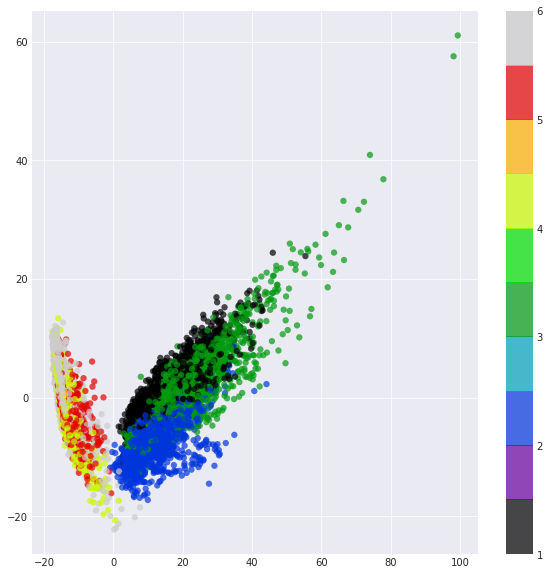

In [100]:
plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

Обучите модель `K-means`, используя сжатые наблюдения (`X_pca`), параметры:
- n_clusters = number of clusters
- n_init = 100
- random_state = RANDOM_STATE

In [101]:
kmeans = KMeans(n_clusters=2, random_state=7).fit(X_pca)
X_kmeans = kmeans.transform(X_pca)

Визуализируйте данные, используя первые 2 компоненты, но теперь окрасьте точки в соответствии с построенным разбиением.

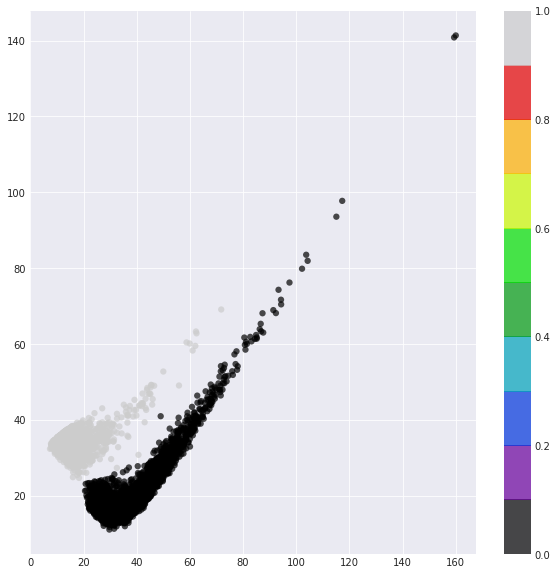

In [104]:
plt.figure(figsize=(10, 10))
y1 = np.copy(y)
for i in range(y1.shape[0]):
    if (y[i] > 3):
        y1[i] = 1
    else:
        y1[i] = 0
plt.scatter(X_kmeans[:, 0], X_kmeans[:, 1], c=y1, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

Посмотрим на соответствие между метками и построенными кластерами

In [105]:
tab = pd.crosstab(y, kmeans.labels_, margins=True)
tab.index = list(labels_mapping.values()) + ['all']
tab.columns = [f'cluster_{i+1}' for i in range(2)] + ['all']
tab

,cluster_1,cluster_2,all
walking,0,1722,1722
walking upstairs,8,1536,1544
walking downstairs,0,1406,1406
sitting,1774,3,1777
standing,1906,0,1906
laying down,1932,12,1944
all,5620,4679,10299


Можно увидеть, что каждый класс попал в несколько кластеров. Давайте рассмотрим максимальный процент объектов в классе, которые попали в один кластер. Например, если в классе 1406 примеров и разбиение на классы:
- 900
- 500
- 6  
то значений такой метрики будет $\frac{900}{1406} \approx 0.64$

Такая простая метрика показывает, насколько класс отделим от других.

Посчитайте такую метрику для каждого класса.

**Вопрос 4.** Отсортируйте класс в порядке уменьшения метрики. В качестве ответа, укажите номера классов через пробел

1 - walking, 2 - walking upstairs, 3 - walking downstairs, 4 - sitting, 5 - standing, 6 - laying down

Возможно, что 6 $-$ не лучшее число кластеров. Определите с помощью метода "локтя", оптимальное число кластеров.

**Вопрос 5.** Какое число кластеров оптимально?

In [ ]:
inertia = []
for k in tqdm_notebook(range(1, 7)):
    pass

In [ ]:
plt.plot(range(1, 7), inertia, marker='s');

Давайте попробуем другой тип кластеризации $-$ агломеративную кластеризацию.

Обучите её на сжатых данных, в качестве количества кластеров укажите число классов, а параметр `linkage` $-$ `ward`

In [ ]:
ag = None

Сравните полученную модель с `K-means` из 4 вопроса с помощью метрики $ARI$

In [ ]:
print('KMeans: ARI =', None)
print('Agglomerative CLustering: ARI =', None)

**Вопрос 6.** Выберите верные утверждения

- Согласно $ARI$, агломеративная кластеризация работает лучше, чем k-means;
- Если перенумеровать классы, то значение метрики не изменится;
- Для случайного разделения на классы, метрика будет близка к 0;
- Метрику $ARI$ можно использовать, даже когда нет истинных меток класса.

Для определения типа активности можно решать и задачу мультиклассовой классификации, так как уже известны метки классов. Воспользуемся моделью `LinearSVC`, а для подбора оптимальных параметров будем использовать поиск по сетке и кросс-валидацию. Почитать про это можно [тут](https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f).

- Используйте `StandartScaler` для стандартизирования данных, но обучите его только на тренировочных данных
- Подберите параметр `C` с помощью `GridSearchCV`, параметр `cv` установите 3

In [ ]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [ ]:
X_train_scaled = None
X_test_scaled = None

In [ ]:
best_svc = GridSearchCV(...)
best_svc.fit(X_train_scaled, y_train)

In [ ]:
best_svc.best_params_, best_svc.best_score_

**Вопрос 7.** Какой оптимальный параметр?

In [ ]:
y_predicted = best_svc.predict(X_test_scaled)

In [ ]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = list(labels_mapping.values()) + ['all']
tab.columns = list(labels_mapping.values()) + ['all']
tab

Посчитайте снова метрику отделимости каждого класса.

**Вопрос 8.** Линейный классификатор справился лучше, чем k-means?

**Вопрос 9.** Какая активность хуже всего распознаётся линейным классификатором?

**Вопрос 10.** Выберите верные утверждения

- PCA позволяет ускорить время обучения, но качество, как правило, становится хуже;
- С помощью PCA можно визуализировать данные на плоскости, но это не единственный способ, например, можно использовать t-SNE;
- Каждая компонента PCA $-$ это линейная комбинация исходных параметров.